In [11]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
from pathlib import Path
import time
import math
from typing import Union
import os
import numpy as np
import torch
import cv2
from torch import Tensor
from tqdm import tqdm
import nvdiffrast.torch as dr
import matplotlib.pyplot as plt
import tree_segmentation as ts
from semantic_sam import semantic_sam_l
from segment_anything import build_sam
import torch_geometric as pyg
from tree_segmentation.extension import Mesh, ops_3d, utils
from tree_segmentation import Tree2D, Tree3D, choose_best_views, random_camera_position
from paper.paper_util import get_2d_tree_from_3d
import open3d as o3d
import struct

/home/wan/Projects/Segmentation/TreeSeg


In [3]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline
device = torch.device('cuda')
torch.set_grad_enabled(False)
glctx = dr.RasterizeCudaContext()

2.2.1+cu121
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
mesh_path = Path('~/data/meshes/winter_scene/low_poly_winter_scene.obj').expanduser().resolve()
print('mesh path:', mesh_path)
cache_dir = Path(f'./results/{ts.get_hash_name(mesh_path)}')
print('cache dir:', cache_dir)

mesh path: /home/wan/data/meshes/winter_scene/low_poly_winter_scene.obj
cache dir: results/meshes_winter_scene_low_poly_winter_scene


In [5]:
cache_file = cache_dir.joinpath(mesh_path.name).with_suffix('.mesh_cache')
if cache_file.exists() and 1:
    mesh = torch.load(cache_file, map_location=device)  # type: Mesh
else:
    mesh = Mesh.load(mesh_path)
    mesh.float()
    mesh.int()
    mesh = mesh.unit_size()
    # mesh_ = mesh.to_open3d()
    # print(mesh_)
    # mesh_smp = mesh_.simplify_quadric_decimation(target_number_of_triangles=500_000, maximum_error=0.1)
    # mesh_smp = mesh_.simplify_vertex_clustering(target_number_of_triangles=500_000, maximum_error=0.5)
    # o3d.io.write_triangle_mesh(cache_dir.joinpath('simplified.ply').as_posix(), mesh_smp)
    # mesh = mesh.from_open3d(mesh_smp).cuda().unit_size()
    # print(mesh)
    mesh = mesh.cuda().unit_size()
    cache_dir.mkdir(exist_ok=True)
    torch.save(mesh, cache_file)
    print('save cached mesh to', cache_file)
mesh.compute_tangents_()
print(mesh)

save cached mesh to results/meshes_winter_scene_low_poly_winter_scene/low_poly_winter_scene.mesh_cache
Mesh(vertices=133234, faces=66051, tex, nrm, tng, mat=['name', 'ka', 'kd', 'ks', 'bsdf'])


# 2D Rendering and Segmentation

In [6]:
N = 100
fovy = math.radians(60)
image_size = 1024
if cache_dir.joinpath('Tw2v.pth').exists():
    Tw2vs = torch.load(cache_dir.joinpath('Tw2v.pth'), map_location=device)
else:
    ## 球面上的均匀格点
    # seq = torch.arange(N, device=device)
    # c = (math.sqrt(5) - 1) * math.pi
    # z = ((seq * 2 - 1) / N - 1).clamp(-1, 1)
    # x = torch.sqrt(1 - z * z) * (seq * c).cos()
    # y = torch.sqrt(1 - z * z) * (seq * c).sin()
    # eye = torch.stack([x, y, z], dim=-1) * 2.5
    # eye = eye * (torch.ones((N, 1), device=device))  # * (radius_range[1] - radius_range[0]) + radius_range[0])
    ## 随机采点
    N = N * 10
    phi_range = [0, math.pi * 2.]
    cos_theta_range = [math.cos(math.pi * 0.01), math.cos(math.pi * 0.5)]
    phis = torch.rand((N,), device=device) * (phi_range[1] - phi_range[0]) + phi_range[0]
    thetas = torch.arccos(
        torch.rand((N,), device=device) * (cos_theta_range[1] - cos_theta_range[0]) + cos_theta_range[0])
    radius = torch.full((N,), 1.8, device=device)
    eye = ops_3d.coord_spherical_to(radius, thetas, phis).to(device)
    Tw2vs = ops_3d.look_at(eye, torch.zeros_like(eye))
    print(utils.show_shape(Tw2vs))

    ## 最优选点
    # print(mesh.AABB)
    # random_camera_position(mesh, )
    N = N // 10
    Tv2c = ops_3d.perspective(fovy=fovy, size=(image_size, image_size), device=device)
    Tw2vs = Tw2vs[choose_best_views(glctx, mesh, Tv2c @ Tw2vs, N, image_size)]
    torch.save(Tw2vs, cache_dir.joinpath('Tw2v.pth'))
print(utils.show_shape(Tw2vs))


/home/wan/Projects/Segmentation/TreeSeg/tree_segmentation/extension/ops_3d/coord_trans.py:186: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:63.)
  y_axis = torch.cross(dir_vec, y_axis).norm(dim=-1, keepdim=True) < 1e-6


F32Tensor[1000, 4, 4]
Best the average number of viewed faces: tensor(16.6449, device='cuda:0')
F32Tensor[100, 4, 4]


F32Tensor[100, 1024, 1024, 3], IntTensor[100, 1024, 1024]


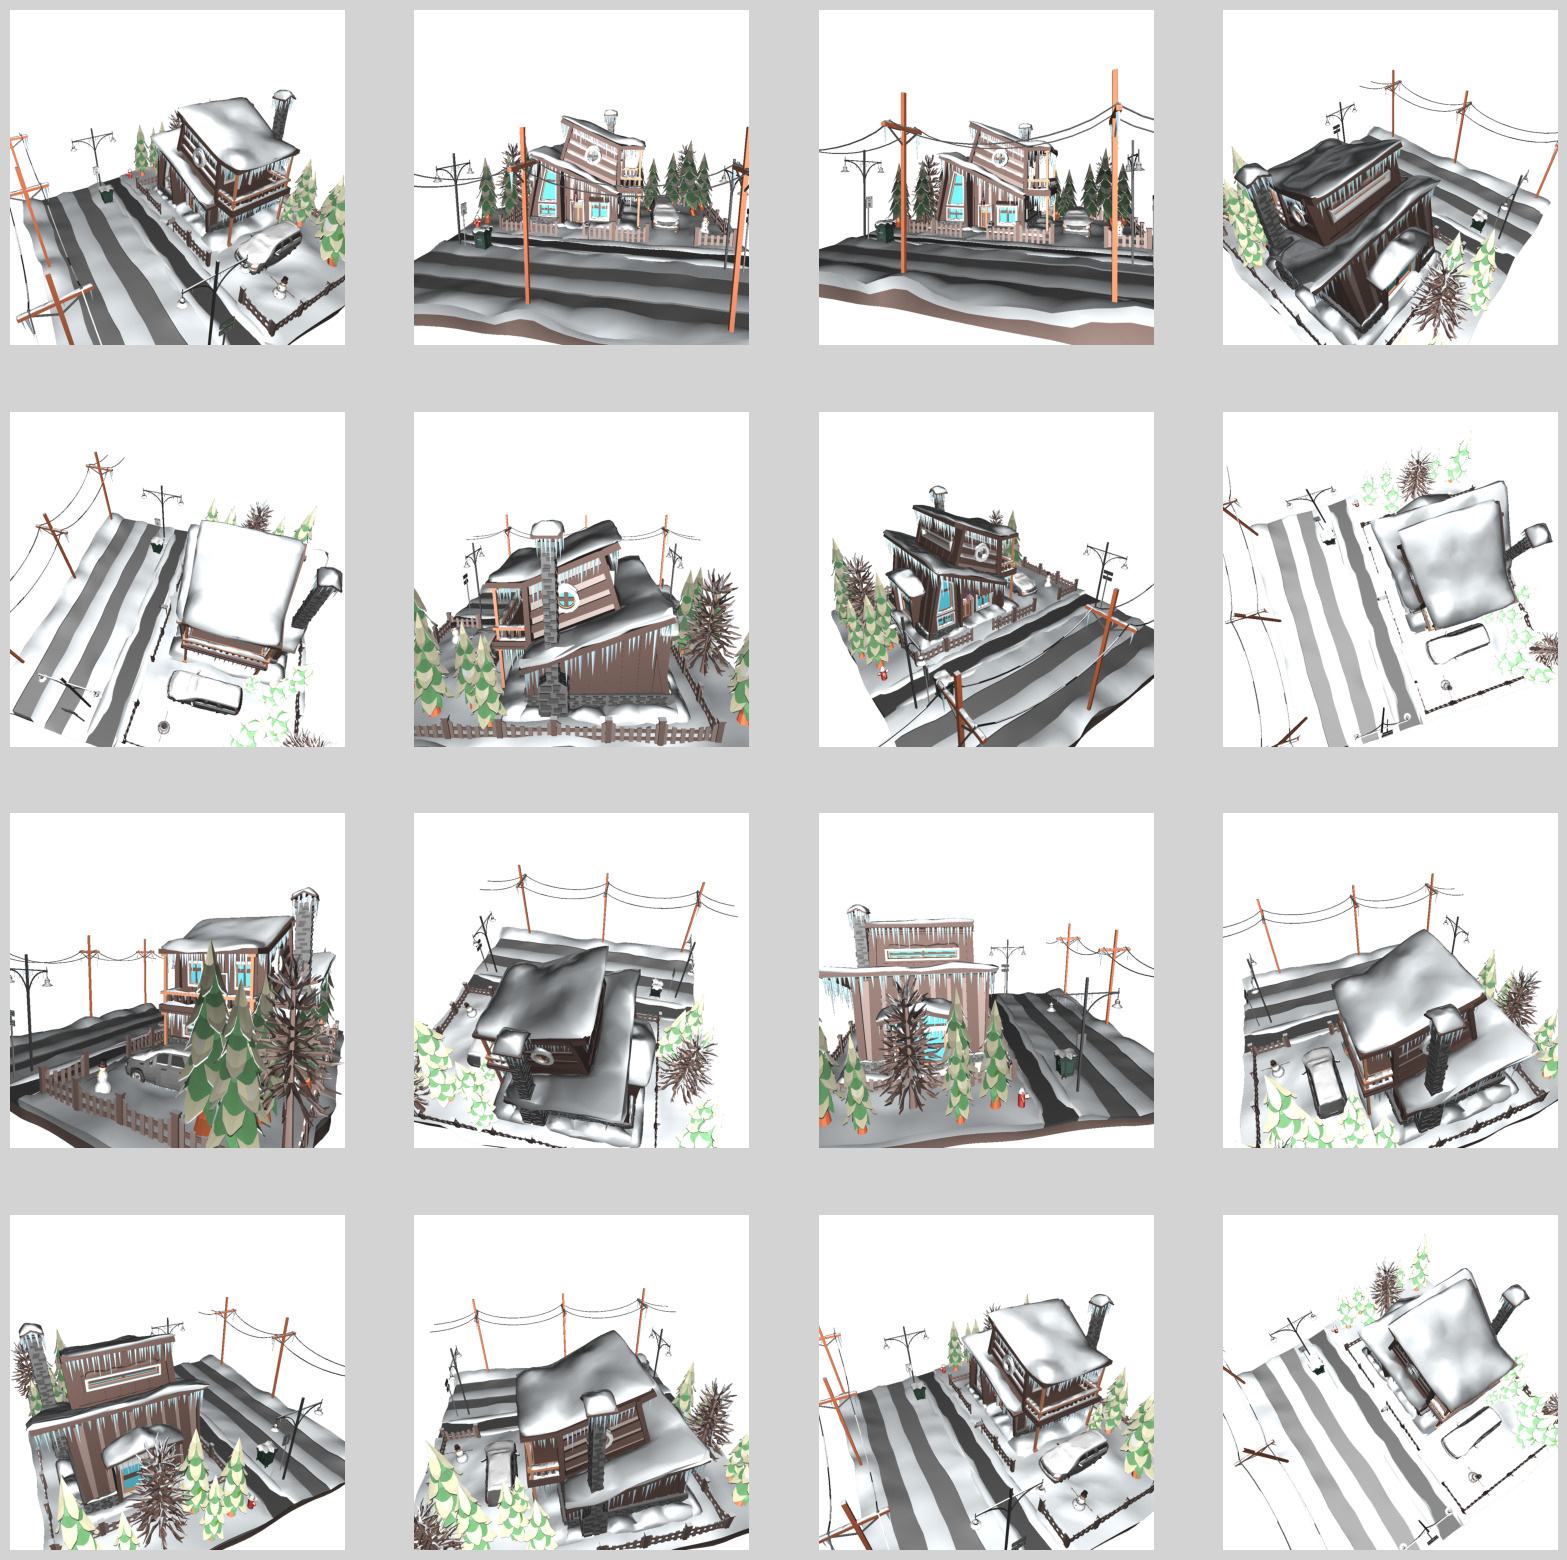

In [7]:
images, tri_ids = [], []
for i in range(0, N, 10):
    images_i, tri_ids_i = ts.render_mesh(
        glctx, mesh, Tw2v=Tw2vs[i:i + 10], image_size=image_size, fovy=fovy, background=1)
    images.append(images_i.cpu())
    tri_ids.append(tri_ids_i.cpu())
images, tri_ids = torch.cat(images), torch.cat(tri_ids)
print(utils.show_shape(images, tri_ids))
plt.figure(figsize=(20, 20), facecolor='lightgray')
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    # plt.imshow(images[i].cpu().numpy())
    plt.imshow(images[np.random.randint(0, N)].cpu().numpy())
    plt.axis('off')

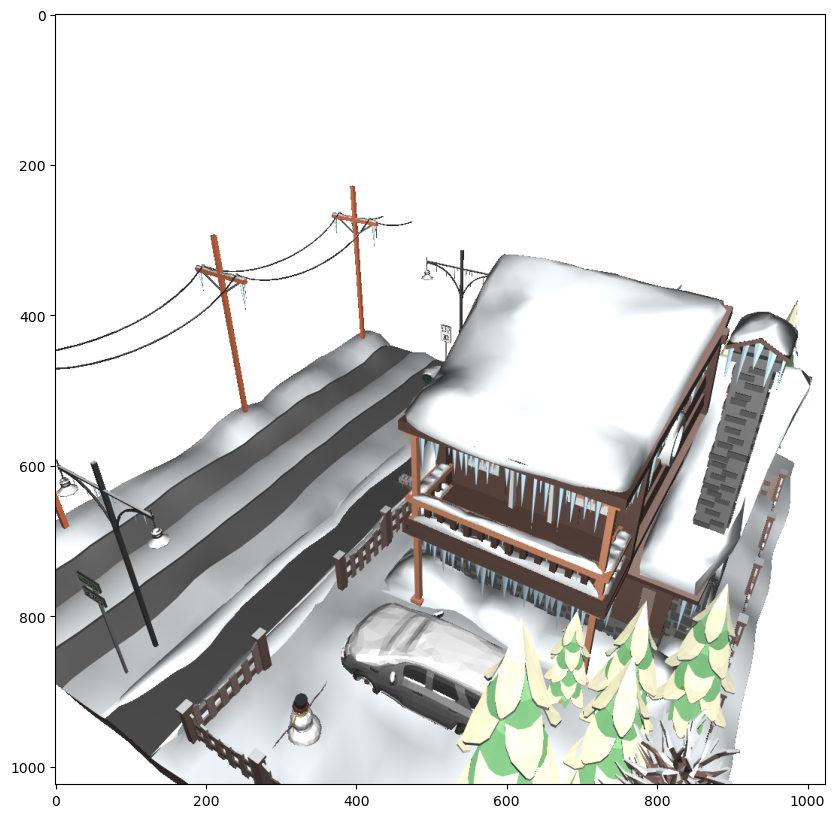

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0].cpu().numpy())

# 2D Segmentation

In [12]:
print(utils.get_GPU_memory())
# ckpt_path = Path("./weights/swinl_only_sam_many2many.pth").expanduser()
# model = semantic_sam_l(ckpt_path).eval().to(device)

ckpt_path = Path("./weights/sam_vit_h_4b8939.pth").expanduser()
model = build_sam(ckpt_path).eval().to(device)

predictor = ts.TreePredictor(model, stability_score_thresh=0.92, points_per_batch=256)
print(utils.get_GPU_memory())

(1.0079641342163086, 31.7391357421875)
(3.457749843597412, 31.7391357421875)


image: F32Tensor[1024, 1024, 3]
(12.562841415405273, 31.7391357421875)
(3.4594836235046387, 31.7391357421875)


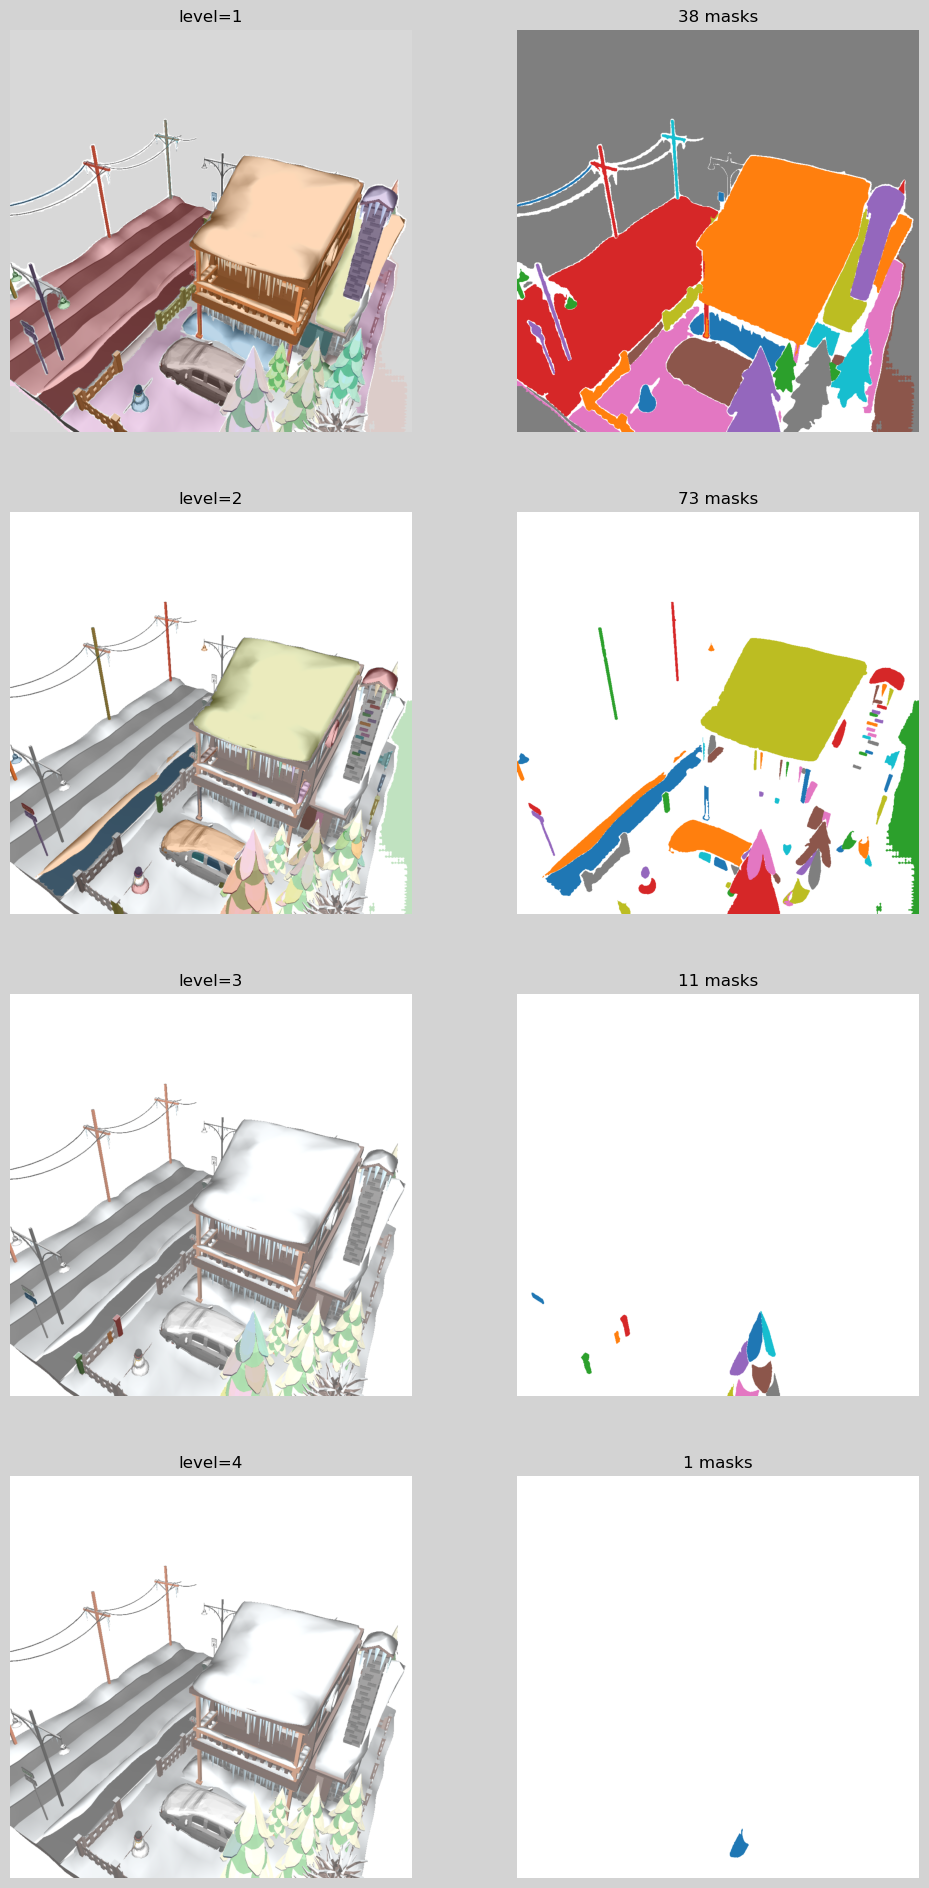

In [13]:
show_index = 0
image = images[show_index, :, :, :3]
print('image:', utils.show_shape(image))
tree_data = predictor.tree_generate(
    (image.cpu().numpy() * 255).astype(np.uint8),
    max_steps=100,
    in_threshold=0.8,
    union_threshold=0.1,
    min_mask_region_area=100,
    points_per_update=256,
    device=device,
    in_thre_area=50,
)
ts.show_all_levels(image, tree_data, facecolor='lightgray', width=6)
print(utils.get_GPU_memory())
del tree_data
torch.cuda.empty_cache()
print(utils.get_GPU_memory())

In [14]:
# from rich.progress import track
from IPython.display import clear_output

for index in tqdm(range(N)):
    if 1 and cache_dir.joinpath(f"view_{index:04d}.data").exists():
        continue
    tree_data = predictor.tree_generate(
        (images[index, :, :, :3].cpu().numpy() * 255).astype(np.uint8),
        max_steps=100,
        in_threshold=0.8,
        union_threshold=0.1,
        min_mask_region_area=100,
        points_per_update=256,
        device=device,
        in_thre_area=50,
    )
    data = {
        'tree_data': tree_data.save(filename=None),
        'tri_id': tri_ids[index].clone(),
        'image': images[index].clone(),
        'Tw2v': Tw2vs[index].clone(),
    }
    torch.save(data, cache_dir.joinpath(f"view_{index:04d}.data"))

    clear_output(wait=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:51:43<00:00, 67.03s/it]


# 3D Segmentation

In [15]:
tree3d = Tree3D(mesh, device=device, verbose=1)
# tree3d.load(cache_dir.joinpath('my.tree3dv2'))
tree3d.load_2d_results(cache_dir, pack=True)
print(tree3d.masks_2d.shape)

[Tree] reset
[Tree3D] GPU: (12.909063816070557, 31.7391357421875)
[Tree3D] There are 100 data
[Tree3D] {'tree_data': {'parent': IntTensor[119], 'first': IntTensor[119], 'next': IntTensor[119], 'last': IntTensor[119], 'cnt': 118, 'num_samples': IntTensor[119], 'masks': (Uint8Tensor[1090084], IntTensor[118, 1024], (118, 1024, 1024), 'enc'), 'scores': F32Tensor[118], 'format': 'enc', 'extra': {}}, 'tri_id': IntTensor[1024, 1024], 'image': F32Tensor[1024, 1024, 3], 'Tw2v': F32Tensor[4, 4]}
[Tree3D] Load 100 views
[Tree3D] GPU: (3.459413528442383, 31.7391357421875)
[Tree3D] view_masks, view_infos[0]: BoolTensor[100, 66051], (IntTensor[9846], LongTensor[9846])
[Tree3D] loaded 100 views, 11541 masks, max_num: 219
[Tree3D] GPU: (4.6446967124938965, 31.7391357421875)
torch.Size([365, 66051])


/home/wan/Projects/Segmentation/TreeSeg/tree_segmentation/tree_3d_segmentation.py:259: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  self._masks_2d_sp = torch.sparse.FloatTensor(


In [16]:
# Gv = tree3d.build_view_graph()
# Gm = tree3d.build_graph(Gv)
A = tree3d.build_all_graph()
X, autoencoder = tree3d.compress_masks(epochs=3000)
print(autoencoder)
print(utils.get_GPU_memory())

[Tree3D] start build view graph
[Tree3D] start build graph
[Tree3D] X epoch[   0], loss: recon= 0.711, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.153, lr=9.972e-04
[Tree3D] X epoch[ 200], loss: recon= 0.017, lr=9.890e-04
[Tree3D] X epoch[ 300], loss: recon= 0.014, lr=9.754e-04
[Tree3D] X epoch[ 400], loss: recon= 0.012, lr=9.566e-04
[Tree3D] X epoch[ 500], loss: recon= 0.011, lr=9.328e-04
[Tree3D] X epoch[ 600], loss: recon= 0.010, lr=9.043e-04
[Tree3D] X epoch[ 700], loss: recon= 0.010, lr=8.714e-04
[Tree3D] X epoch[ 800], loss: recon= 0.008, lr=8.343e-04
[Tree3D] X epoch[ 900], loss: recon= 0.007, lr=7.937e-04
[Tree3D] X epoch[1000], loss: recon= 0.008, lr=7.498e-04
[Tree3D] X epoch[1100], loss: recon= 0.007, lr=7.032e-04
[Tree3D] X epoch[1200], loss: recon= 0.007, lr=6.544e-04
[Tree3D] X epoch[1300], loss: recon= 0.006, lr=6.038e-04
[Tree3D] X epoch[1400], loss: recon= 0.006, lr=5.522e-04
[Tree3D] X epoch[1500], loss: recon= 0.006, lr=5.000e-04
[Tree3D] X epoch[1600], loss:

In [21]:
K = tree3d.Lmax * 2
gnn = pyg.nn.GCN(in_channels=X.shape[1], hidden_channels=128, num_layers=2, out_channels=K, norm='BatchNorm').cuda()
print(gnn)
tree3d.run(epochs=10000, K=K, gnn=gnn, A=A * A.ge(0.5), X=X)

now_date = time.strftime("%m-%d_%H:%M:%S", time.localtime(time.time()))
tree3d.save(cache_dir.joinpath(f'my_{now_date}.tree3d'))

GCN(256, 438, num_layers=2)
[Tree3D] GPU: (5.7799577713012695, 31.7391357421875)
[Tree3D] GPU: (6.282623767852783, 31.7391357421875)
loss weights: {'match': 1, 'view': 1, 'mv': 1, 'recon': 1, 't2d': 1, 'tree': 0.1, 'vm': 1}
[Tree3D] Epoch 100: loss=2.454773, t2d= 0.010, recon= 0.003, match= 0.925, view= 0.364, vm= 0.940, mv= 0.239, tree= 1.515
[Tree3D] Epoch 200: loss=2.352432, t2d= 0.009, recon= 0.002, match= 0.833, view= 0.340, vm= 0.864, mv= 0.233, tree= 1.221
[Tree3D] Epoch 300: loss=2.117960, t2d= 0.008, recon= 0.002, match= 0.749, view= 0.310, vm= 0.798, mv= 0.202, tree= 0.991
[Tree3D] Epoch 400: loss=2.415426, t2d= 0.007, recon= 0.002, match= 0.746, view= 0.312, vm= 0.793, mv= 0.218, tree= 0.894
[Tree3D] Epoch 500: loss=1.938411, t2d= 0.007, recon= 0.002, match= 0.710, view= 0.290, vm= 0.763, mv= 0.192, tree= 0.842
[Tree3D] Epoch 600: loss=2.319030, t2d= 0.006, recon= 0.002, match= 0.686, view= 0.274, vm= 0.741, mv= 0.182, tree= 0.800
[Tree3D] Epoch 700: loss=1.657510, t2d= 0.00

0: Tree Root
├── 136
├── 135
├── 133
├── 132
├── 130
├── 126
├── 125
│   └── 108
├── 123
├── 121
├── 117
├── 116
├── 115
├── 109
├── 106
├── 105
├── 103
├── 102
├── 100
│   ├── 138
│   ├── 124
│   ├── 114
│   ├── 101
│   ├── 17
│   │   └── 23
│   ├── 34
│   │   └── 91
│   └── 72
│       ├── 137
│       ├── 76
│       ├── 19
│       └── 67
├── 99
├── 98
├── 95
│   ├── 63
│   │   └── 22
│   └── 69
│       └── 119
├── 94
├── 92
├── 90
├── 85
├── 83
├── 81
├── 80
│   ├── 97
│   ├── 96
│   └── 58
├── 77
├── 75
├── 74
├── 71
│   ├── 79
│   ├── 39
│   └── 41
├── 65
├── 64
├── 62
│   ├── 131
│   ├── 110
│   ├── 82
│   ├── 43
│   ├── 47
│   └── 57
├── 61
├── 60
├── 59
├── 56
│   └── 93
├── 55
├── 54
├── 53
├── 51
├── 49
│   └── 66
├── 46
├── 45
├── 42
├── 40
├── 37
│   └── 107
├── 36
├── 33
├── 32
│   ├── 113
│   └── 7
├── 30
│   ├── 120
│   ├── 112
│   ├── 84
│   ├── 14
│   │   ├── 89
│   │   ├── 68
│   │   └── 44
│   └── 18
├── 29
├── 28
├── 26
├── 25
├── 24
├── 21
│   └── 52
├── 20
├── 16
├── 15
├── 13
├── 12
├── 11
├── 10
├── 9
│   └── 127
├── 8
│   └── 38
├── 6
│   └── 78
├── 5
├── 3
│   ├── 48
│   └── 4
├── 2
│   └── 73
└── 1
    └── 88

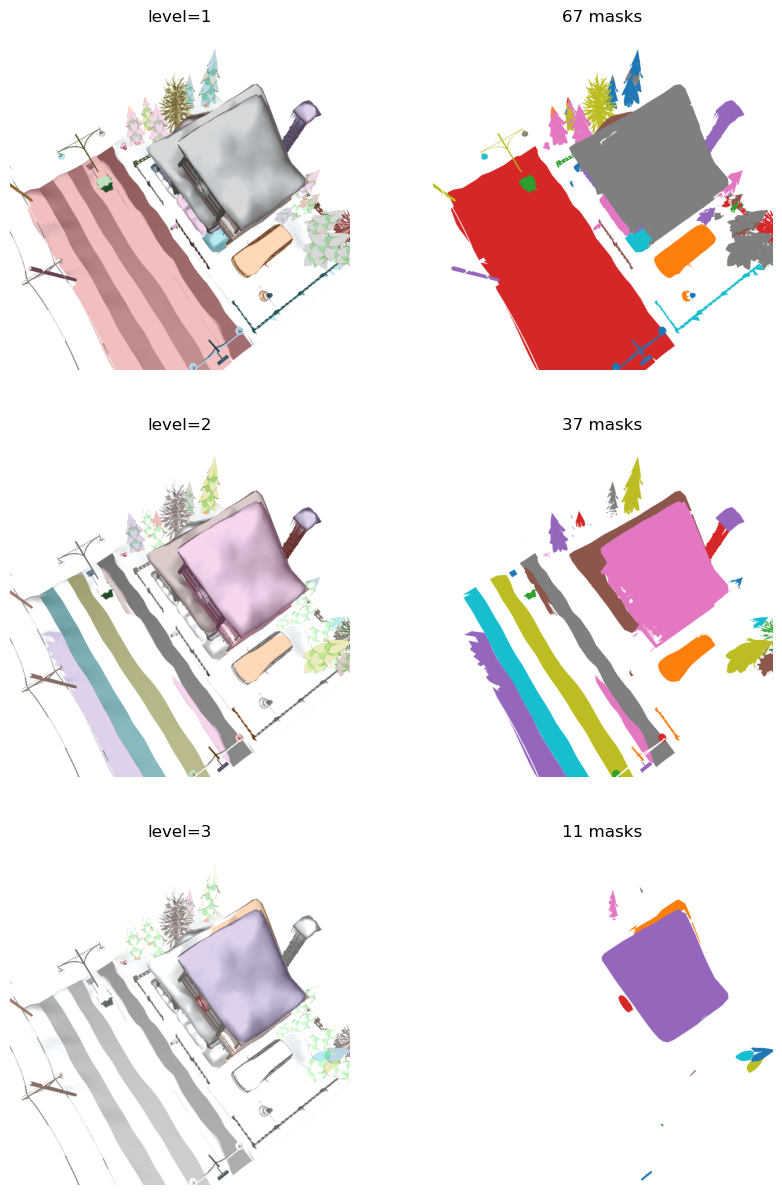

In [23]:
show_index = 8
ts.show_all_levels(images[show_index, :, :, :3], tree3d, tri_ids[show_index])
tree3d.print_tree()

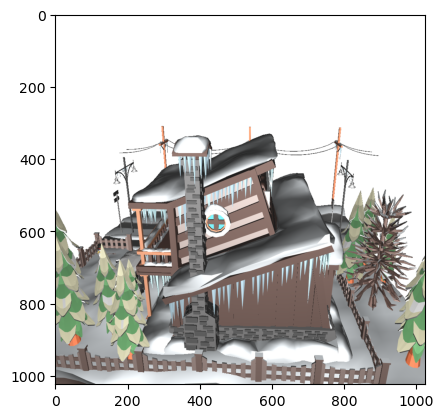

In [54]:
def save_results(index, alpha=0.5):
    image = images[index]
    utils.save_image(cache_dir.joinpath(f'view_{index}.png'), image)
    plt.imshow(image.cpu().numpy())
    plt.show()
    return
  
    tree2d = get_2d_tree_from_3d(tree3d, tri_ids[index].to(device))    
    image = image.cpu().numpy()
    for level, nodes in enumerate( tree2d.get_levels()):
        if level == 0:
            continue
        image_l = image.copy()
        colored_mask = ts.get_colored_masks(tree2d.masks[nodes-1])
        image_l = cv2.addWeighted(image_l, alpha, colored_mask, 1-alpha, 0)
        for x in nodes:
            p = tree2d.parent[x].item() - 1
            x = x.item() - 1
            image_l = ts.image_add_mask_boundary(image_l, tree2d.masks[x], color=(0, 0, 0), kernel_size=5)
            # image_l = ts.image_add_mask_boundary(image_l, tree2d.masks[p],color=(0, 0, 0),  kernel_size=9)
        utils.save_image(cache_dir.joinpath(f'view_{index}_l{level}.png'), image_l)
        plt.imshow(image_l)
        plt.show()


# for i in range(22):
save_results(22)